# Train on Core Features

Copyright 2019 IBM Corp.

# Load Processed Data

* This data was created by running the notebook prepare-data.ipynb

In [50]:
import pickle, os

home_dir = "../data"
processed_data_pkl = os.path.join(home_dir, "processed_data.pkl")

with open(processed_data_pkl, 'rb') as f:
    data_df, exclude_features, analytics = pickle.load( f)

print(data_df.shape)

(1301293, 85)


In [51]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

# Some statistics

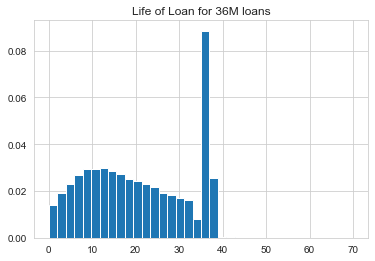

In [52]:
short_df = data_df.loc[data_df['term']<0.5,:]

plt = short_df['LifeOfLoan'].hist(cumulative=False, density=1, bins=36)
plt.title.set_text("Life of Loan for 36M loans")

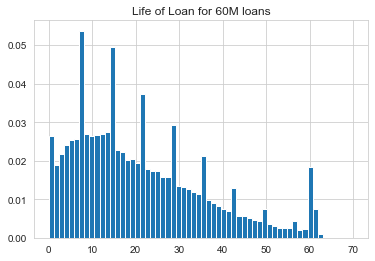

In [53]:
long_df = data_df.loc[data_df['term']>0.5,:]

plt = long_df['LifeOfLoan'].hist(cumulative=False, density=1, bins=60)
plt.title.set_text("Life of Loan for 60M loans")

5.31 30.99


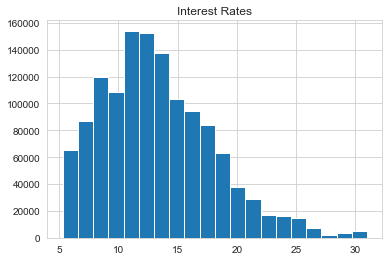

In [54]:
plt = data_df['int_rate'].hist(bins=20)
plt.title.set_text("Interest Rates")
print(data_df.int_rate.min(), data_df.int_rate.max())

In [55]:
del short_df
del long_df

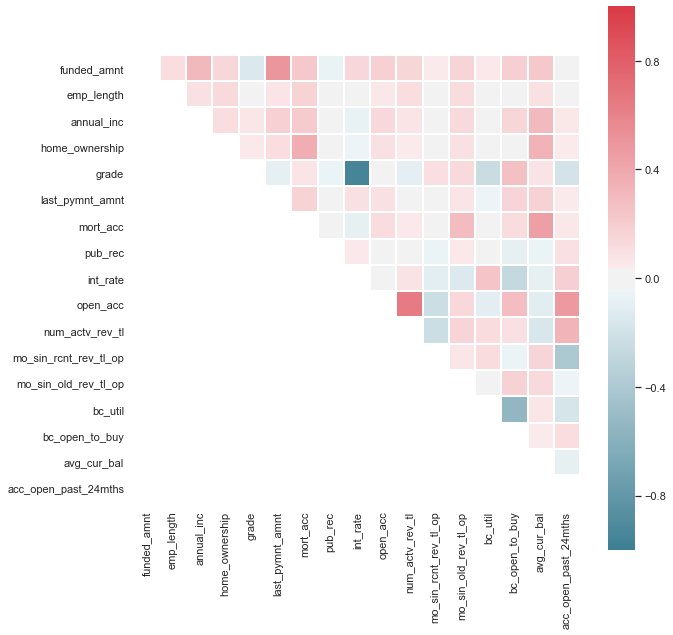

In [56]:
import matplotlib.pyplot as plt

core_features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths"]

dataViz = data_df[core_features]
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

## Principle Component Analysis

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# feature normalization (feature scaling)
X_scaler = StandardScaler()
x = X_scaler.fit_transform(data_df[core_features])

# PCA
pca = PCA(n_components=0.9)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [58]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[0.16095247 0.14550902 0.12637927 0.07992577 0.07011151 0.06061016
 0.0542606  0.05219672 0.04786273 0.04359596 0.035724   0.0307912 ]
[0.16095247 0.30646149 0.43284077 0.51276653 0.58287804 0.6434882
 0.6977488  0.74994552 0.79780825 0.84140421 0.87712822 0.90791941]


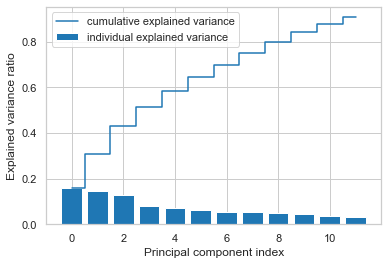

In [59]:
lenth = len(pca.explained_variance_ratio_)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(0,lenth),var_exp,align='center',label='individual explained variance')
plt.step(range(0,lenth),cum_var_exp,where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [61]:
core_features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade'
                 , "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths"]

# Generate train, test, and validate sets 

In [62]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20, 10
rcParams['font.size'] = 22

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [63]:
def print_score(clf, X_train, y_train, X_test, y_test, train=False, plot_features=False, features=None):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  
        
    if plot_features and features is not None:
        # Get top features
        feature_importances = pd.DataFrame(clf.feature_importances_, 
                                   index = features,
                                   columns=['importance']).\
                                   sort_values('importance',ascending=False)
        # Plot
        feature_importances.iloc[:10,:].plot(kind='barh')
        plt.show()

In [64]:
# split validate set
v_size = 0.5
idx, idx_validate = \
            train_test_split(data_df.index, test_size=v_size, random_state=101)

# split train / test sets
test_size = 0.15
idx_train, idx_test = \
            train_test_split(idx, test_size=test_size)

# Define train, test, and validate df
train_df    = data_df.loc[idx_train, :]
test_df     = data_df.loc[idx_test, :]
validate_df = data_df.loc[idx_validate, :]

print("Number of loans in Train    set: {}".format(train_df.shape[0]))
print("Number of loans in Test     set: {}".format(test_df.shape[0]))
print("Number of loans in Validate set: {}".format(validate_df.shape[0]))

Number of loans in Train    set: 553049
Number of loans in Test     set: 97597
Number of loans in Validate set: 650647


# Rebalancing by SMOTE

In [77]:
from imblearn.over_sampling import SMOTE

smo = SMOTE(random_state=42)
X, y = smo.fit_sample(train_df[core_features], train_df["LoanStatus"])

In [78]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
             "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths"]
y.columns=['LoanStatus']
X['LoanStatus'] = y
train_df_1 = X

# Train different classifier (use core features)


## Random Forest Classifier

In [67]:
def train_and_score(data_train, data_test, features, target, score=False, plot_features=False):
    
    print("Extracting train and test data")
    
    X_train = data_train[features]
    y_train = data_train[target]
    
    print('\tX_train shape: {} \t y_train shape: {}'.format(X_train.shape, y_train.shape))

    X_test = data_test[features]
    y_test = data_test[target]
    
    print('\tX_test  shape: {} \t y_test  shape: {}'.format(X_test.shape, y_test.shape))

    # Train Loan Acceptance classifier
    print("Training classifier")
    acceptance_classifier = RandomForestClassifier(n_estimators=40, random_state=21, class_weight=None)
    out = acceptance_classifier.fit(X_train, y_train)
    print(out)
    
    if score:
        print_score(acceptance_classifier, 
                X_train, y_train, 
                X_test,  y_test , train=False, plot_features=plot_features)
    
    return acceptance_classifier

In [68]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}


# Train classifier with balanced core features
clf_core = train_and_score(train_df_1, test_df, core_features, 'LoanStatus', **options )

Extracting train and test data
	X_train shape: (885298, 16) 	 y_train shape: (885298,)
	X_test  shape: (97597, 16) 	 y_test  shape: (97597,)
Training classifier
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)
Test Result:

accuracy score: 0.7963

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.97      0.88     77985
         1.0       0.47      0.10      0.17     19612

    accuracy                           0.80     97597
   macro avg  

## Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

def train_and_score(data_train, data_test, features, target, score=False, plot_features=False):
    
    print("Extracting train and test data")
    
    X_train = data_train[features]
    y_train = data_train[target]
    
    print('\tX_train shape: {} \t y_train shape: {}'.format(X_train.shape, y_train.shape))

    X_test = data_test[features]
    y_test = data_test[target]
    
    print('\tX_test  shape: {} \t y_test  shape: {}'.format(X_test.shape, y_test.shape))

    # Train Loan Acceptance classifier
    print("Training classifier")
    acceptance_classifier = LogisticRegression(random_state=21)
    out = acceptance_classifier.fit(X_train, y_train)
    print(out)
    
    if score:
        print_score(acceptance_classifier, 
                X_train, y_train, 
                X_test,  y_test , train=False, plot_features=plot_features)
    
    return acceptance_classifier

In [70]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}


# Train classifier with balanced core features
clf_core = train_and_score(train_df_1, test_df, core_features, 'LoanStatus', **options )

Extracting train and test data
	X_train shape: (885298, 16) 	 y_train shape: (885298,)
	X_test  shape: (97597, 16) 	 y_test  shape: (97597,)
Training classifier


/Users/jieqian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Test Result:

accuracy score: 0.5844

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.56      0.68     77985
         1.0       0.28      0.68      0.40     19612

    accuracy                           0.58     97597
   macro avg       0.58      0.62      0.54     97597
weighted avg       0.76      0.58      0.63     97597


Confusion Matrix: 
 [[43652 34333]
 [ 6232 13380]]



## XGBoost

In [71]:
from xgboost import XGBClassifier

def lgcpcatrain_and_score(X_train_pc, y_trai, X_test_pc, y_tes):
    
    xcl=XGBClassifier()
    print("Extracting train and test data")
    
    X_train_2 = X_train_pc
    y_train_2 = y_trai
    
    print('\tX_train shape: {} \t y_train shape: {}'.format(X_train_2.shape, y_train_2.shape))

    X_test_2 = X_test_pc
    y_test_2 = y_tes
    
    print('\tX_test  shape: {} \t y_test  shape: {}'.format(X_test_2.shape, y_test_2.shape))

    # Train Loan Acceptance classifier
    print("Training classifier")
    acceptance_classifier = xcl
    out = acceptance_classifier.fit(X_train_2, y_train_2)
    print(out)
    
    print_score(acceptance_classifier, 
                X_train_2, y_train_2, 
                X_test_2,  y_test_2 , train=False)

    
    return acceptance_classifier

In [72]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}

#definition of the core feature X and y
X_train = train_df_1[core_features]
y_train = train_df_1['LoanStatus']
X_test = test_df[core_features]
y_test = test_df['LoanStatus']

# Train classifier with balanced core features
clf_core=lgcpcatrain_and_score(X_train, y_train, X_test, y_test)

Extracting train and test data
	X_train shape: (885298, 16) 	 y_train shape: (885298,)
	X_test  shape: (97597, 16) 	 y_test  shape: (97597,)
Training classifier
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Test Result:

accuracy score: 0.8014

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.98      0.89     77985
         1.0       0.54      0.08      0.14

# Balancing by undelsampling

In [79]:
df_fully_paid = train_df[train_df["LoanStatus"] == 0]
df_charged_off = train_df[train_df["LoanStatus"] == 1]
subset_of_df_fully_paid = df_fully_paid.sample(n=100000)
subset_of_df_charged_off = df_charged_off.sample(n=100000)
train_df_1 = pd.concat([subset_of_df_fully_paid,subset_of_df_charged_off])

In [80]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}

X_train = train_df_1[core_features]
y_train = train_df_1['LoanStatus']
X_test = test_df[core_features]
y_test = test_df['LoanStatus']

# Train classifier with balanced core features
clf_core=lgcpcatrain_and_score(X_train, y_train, X_test, y_test)

Extracting train and test data
	X_train shape: (200000, 16) 	 y_train shape: (200000,)
	X_test  shape: (97597, 16) 	 y_test  shape: (97597,)
Training classifier
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Test Result:

accuracy score: 0.6401

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.89      0.63      0.74     77985
         1.0       0.32      0.68      0.43

In [81]:
charge_off_classifier_core_pkl = os.path.join(home_dir, "co_clf_core.pkl")

with open(charge_off_classifier_core_pkl,'wb') as f:
    pickle.dump((data_df, idx_train, idx_test, idx_validate, clf_core, core_features, analytics), f)